# Pole Figures on SSRL 7-2

### Import python libraries

In [1]:
# numpy and plotting
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'DejaVu Sans'
                })

%config InlineBackend.figure_format = 'retina'

import bokeh
from bokeh.plotting import figure, show, output_file, output_notebook, reset_output
from coffeetools import coffee

# Data handling
import glob
import os
import pandas as pd

# pyFAI
import pyFAI
from pyFAI.multi_geometry import MultiGeometry
from pyFAI.calibrant import get_calibrant
# from pyFAI.gui import jupyter

# pygix
import pygix
import fabio
from pygix import plotting as ppl

# Peak Fitting
from lmfit.models import GaussianModel, LorentzianModel, ExponentialModel, ConstantModel, LinearModel, VoigtModel

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def my_implot(data, x=None, y=None, mode=None,
           xlim=None, ylim=None, xlabel=None, ylabel=None,
           cmap=None, clim='auto', colorbar=False,
           newfig=True, show=True, tight_layout=True,
           filename=None,
           **kwargs):
    """
       Parameters
    ----------
    data : ndarray
        Image data array
    x : ndarray
        x axis scale
    y : ndarray
        y axis scale
    mode : string
        Data type. Accepted values: raw, angular, rsm
    xlim : tuple
        (lower, upper) limit of x axis
    ylim : tuple
        (lower, upper) limit of y axis
    cmap : string
        Valid name of matplotlib colormap
    colorbar : bool
        Add colorbar or not
    clim : 'auto', None or tuple
        z-scaling of image data. If 'auto' will set based on
        (0.5, 99.5) percentile of intensity values; if None uses
        (data.min(), data.max()); otherwise tuple of (min, max).
    newfig : bool
        Specify whether to generate a new figure or not. This is
        useful if you are creating a figure with many subplots,
        using newfig=False will not make a new figure window.
    show : bool
        Specify whether to call plt.show() when plot has been
        created. Again, useful for subplots or batch processing.
    filename : string or None
        If a string is passed the plot will be saved with given
        filename.

    Returns
    -------
    fig : matplotlib.pyplot.figure instance
        If newfig=True, returns the figure object.
    im : matplotlib.pyplot.imshow instance
        Returns only im object if newfig=False, otherwise
        (fig, im).
    """
    
    LABELS_DICT = {
        'raw': ['y (pixels)', 'x (pixels)'],
        'angular': [r'$2\theta_f \: (deg)$', r'$\alpha_f \: (deg)$'],
        'rsm': [r'$q_{xy} \: (nm^{-1})$', r'$q_z \: (nm^{-1})$'],
        'rsma': [r'$q_{xy} \: (\AA^{-1})$', r'$q_z \: (\AA^{-1})$'],
        'polar': [r'$q \: (nm^{-1})$', r'$chi \: (deg)$'],
        'q': [r'$q \: (nm^{-1})$', r'$Intensity \: (a.u.)$'],
        'chi': [r'$chi \: (deg)$', r'$Intensity \: (a.u.)$'],
        'qz': [r'$q_z \: (nm^{-1})$', r'$Intensity \: (a.u.)$'],
        'qxy': [r'$q_{xy} \: (nm^{-1})$', r'$Intensity \: (a.u.)$']}

    if mode and (mode not in ['raw', 'angular', 'rsm', 'rsma', 'polar']):
        raise RuntimeError('pygix.plotting.implot: mode must be raw, angular'
                           ' or rsm')
    if mode == 'raw':
        origin = 'upper'
    else:
        origin = 'lower'

    try:
        xmin, xmax = x[0], x[-1]
    except TypeError:
        xmin, xmax = 0, data.shape[1]
    try:
        ymin, ymax = y[0], y[-1]
    except TypeError:
        ymin, ymax = 0, data.shape[0]
    extent = [xmin, xmax, ymin, ymax]

    if not cmap:
        cmap = default_cmap

    if clim is None:
        vmin, vmax = data.min(), data.max()
    elif clim == 'auto':
        vmin, vmax = np.percentile(data, (0.1, 99.5))
    else:
        vmin, vmax = clim

    if newfig:
        fig = plt.figure()

    if mode == 'polar':
        if kwargs is None:
            kwargs = {}
        kwargs['aspect'] = 0.2

    im = plt.imshow(data,
                    origin=origin,
                    vmin=vmin, vmax=vmax,
                    interpolation='nearest',
                    cmap=cmap,
                    extent=extent,
                    **kwargs)
    ax = plt.gca()

    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])

    if mode:
        try:
            tmp_xlabel, tmp_ylabel = LABELS_DICT[mode]
        except KeyError:
            raise RuntimeError('Invalid mode for pygix.plotting.implot\n')
        if xlabel is None:
            xlabel = tmp_xlabel
        if ylabel is None:
            ylabel = tmp_ylabel
    # plt.xlabel(get_axis_label(xlabel))
    # plt.ylabel(get_axis_label(ylabel))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    if tight_layout:
        plt.subplots_adjust(right=0.85)

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
        
    if newfig:
        return fig, im, ax
    else:
        return im, ax

### Load data files and dark spectra files

In [3]:
system = 'tol_hi_para'
raw_files = glob.glob("F:\\N2200 Project\\data\\ssrl\\7-2\\raw\\{}\\*.raw".format(system))
print(raw_files[0])
peek_files = glob.glob("F:\\N2200 Project\\data\\ssrl\\7-2\\raw\\{}\\*.raw".format("background"))
print(peek_files[0])

F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para\b_rkline_nils_tol_hi_par_background.dat_scan291_0000.raw
F:\N2200 Project\data\ssrl\7-2\raw\background\b_rkline_nils_tol_hi_par_background.dat_scan291_0000.raw


### Parse pdi files for angle positions and build master dataframe for results

In [12]:
def parse_pdi(file):
    
    # Get the fourth line of the pdi file
    lines = []
    with open(file) as in_file:
        for i,line in enumerate(in_file):
            lines.append(line)
            if i>2:
                break

    line4 = lines[-1]
    
    # Split it up and grab the floats
    val_list = []
    for t in line4.replace(';','').split():  # Remove semi-colons from pdi line
        try:
            val_list.append(float(t))
        except ValueError:
            pass
    
    parsed = pd.Series()
    parsed['theta'] = val_list[0]
    parsed['ttheta'] = val_list[1]
    parsed['chi'] = val_list[2]
    parsed['phi'] = val_list[3]
    parsed['gamma'] = val_list[4]
    parsed['mu'] = val_list[5]
    
    return parsed

def build_master_table(raw_file_list, im_shape_pix=(195,487)):

    # Build a DataFrame from the list of .raw file names
    df = pd.DataFrame()
    df['rawPath'] = pd.Series(raw_file_list)
    df['pdiPath'] = df['rawPath'].copy()+'.pdi'
    df['fileName'] = pd.Series([s[-1] for s in df['rawPath'].str.split('\\')])

    # Parse the file name and the associated .pdi file for image metadata
    df['scan'] = df['fileName'].copy() \
        .str.split('_') \
        .apply(lambda l: l[-2]) \
        .apply(lambda s: int(''.join(c for c in s if c.isdigit())))
    df['num'] = df['fileName'].copy() \
        .str.split('_') \
        .apply(lambda l: l[-1]) \
        .apply(lambda s: int(''.join(c for c in s if c.isdigit())))

    df = pd.concat([df, df['pdiPath'].apply(parse_pdi)],
                          axis=1)

    # Convert all .raw files into int32 arrays, store in df
    file2data = lambda f: np.rot90(np.fromfile(f, dtype='int32').reshape((195,487)),1)
    df['rawData'] = df['rawPath'].copy().apply(file2data)

    return df

## Master dataframe for background files

In [13]:
dfbg = build_master_table(peek_files)
dfbg

,rawPath,pdiPath,fileName,scan,num,theta,ttheta,chi,phi,gamma,mu,rawData
0,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,0,0.1,1.9,90.0,-0.7500,1.50,-0.000005,"[[18869, 17170, 15586, 15511, 16622, 17066, 17..."
1,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,1,0.1,1.9,90.0,-0.8752,1.75,-0.000005,"[[4619, 4541, 4644, 4447, 4544, 4554, 4517, 45..."
2,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,2,0.1,1.9,90.0,-1.0000,2.00,-0.000005,"[[237, 243, 249, 264, 246, 260, 247, 216, 225,..."
3,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,3,0.1,1.9,90.0,-1.1248,2.25,-0.000005,"[[215, 231, 211, 210, 209, 209, 201, 205, 215,..."
4,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,4,0.1,1.9,90.0,-1.2500,2.50,-0.000005,"[[201, 201, 192, 202, 175, 205, 201, 178, 204,..."
5,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,5,0.1,1.9,90.0,-1.3752,2.75,-0.000005,"[[189, 173, 184, 164, 182, 210, 189, 176, 190,..."
6,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,6,0.1,1.9,90.0,-1.5000,3.00,-0.000005,"[[182, 170, 180, 152, 172, 167, 172, 162, 166,..."
7,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,7,0.1,1.9,90.0,-1.6248,3.25,-0.000005,"[[167, 156, 156, 150, 148, 153, 167, 158, 137,..."
8,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,8,0.1,1.9,90.0,-1.7500,3.50,-0.000005,"[[153, 157, 147, 150, 161, 145, 146, 151, 147,..."
9,F:\N2200 Project\data\ssrl\7-2\raw\background\...,F:\N2200 Project\data\ssrl\7-2\raw\background\...,b_rkline_nils_tol_hi_par_background.dat_scan29...,291,9,0.1,1.9,90.0,-1.8752,3.75,-0.000005,"[[151, 143, 156, 136, 161, 144, 159, 162, 153,..."


## Master dataframe for raw files, apply background correction

In [16]:
df = build_master_table(raw_files)

correctedData = []

for i,row in df.iterrows():
    try:
        bg_im = dfbg.loc[dfbg['gamma']==row['gamma']].loc[dfbg['ttheta']==row['ttheta']].iloc[0].rawData
    except:
        bg_im = np.zeros(row['imageData'].shape)
    
    correctedData.append( row.rawData - bg_im )

df['imageData'] = correctedData

In [17]:
df.loc[df['scan']==279].loc[df['num']==93]

,rawPath,pdiPath,fileName,scan,num,theta,ttheta,chi,phi,gamma,mu,rawData,imageData
601,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan279_0093...,279,93,0.1,1.9,90.0,86.0,4.0,-0.000005,"[[82, 101, 115, 122, 79, 90, 104, 85, 98, 99, ...","[[-60, -53, -37, -20, -65, -55, -31, -59, -45,..."


### Show raw detector data

<IPython.core.display.Javascript object>


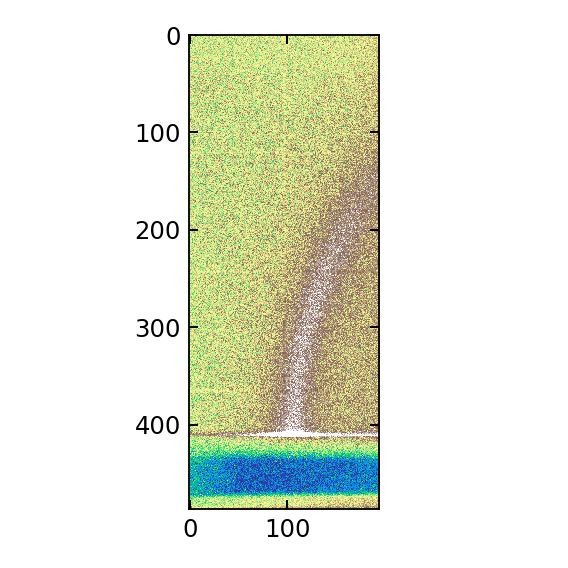

In [18]:
sample = 601
%matplotlib notebook
lmin, lmax = np.percentile(df['imageData'].loc[sample], (1, 99))
plt.figure()
plt.imshow(df['imageData'].loc[sample],cmap='terrain',vmin=lmin,vmax=lmax,origin='upper')

## Save raw image data as image files

In [19]:
def data2img(data):

    # a colormap and a normalization instance
    cmap = plt.cm.terrain
    lmin, lmax = np.percentile(data, (1, 99))
    norm = plt.Normalize(vmin=lmin, vmax=lmax)
    image = cmap(norm(data))
    
    return image

In [15]:
image_dir = os.path.join(os.path.dirname(df['rawPath'].loc[0]),'image')
try:
    os.mkdir(image_dir)
except:
    pass
df['pngPath'] = df['fileName'].copy().apply(
    lambda s: os.path.join(image_dir,s.replace('raw','png')))
df['pngURL'] = 'file:\\\\\\'+df['pngPath'].copy()
print(df['pngURL'].loc[10])

file:\\\F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para\image\b_rkline_nils_tol_hi_par_background.dat_scan291_0010.png


In [11]:
for i,row in df.iterrows():
    plt.imsave(row['pngPath'],data2img(row['imageData']))

## Make some magic

In [74]:
def zoom_img_plot(df,x_col,y_col,image_col,x_label='X',y_label='Y',plot_width = 800, plot_height=600):
    p=figure(sizing_mode='scale_width',
             x_axis_label = x_label,
             y_axis_label = y_label,
             width = plot_width,
             height = plot_height,
             active_scroll = 'wheel_zoom'
            )
    
    x_range = df[x_col].max()-df[x_col].min()
    y_range = df[y_col].max()-df[y_col].min()

    cds = bokeh.models.ColumnDataSource(
        df
    )
    
    circles = p.circle(
        source=cds,
        x=x_col,
        y=y_col,
        size=20,
        fill_alpha=.6,
    )

    p.add_tools(
        bokeh.models.HoverTool(
            tooltips=[
                ('2 theta', '@ttheta'),
                ('gamma','@gamma'),
                ('phi','@phi'),
                ('theta','@theta'),
                ('mu','@mu'),
                ('file','@fileName')
            ]
        )
    )

    images = p.image_url(
        source=cds,
        x=x_col,
        y=y_col,
        w=195,
        h=487,
        w_units='screen',
        h_units='screen',
        url=image_col,
        anchor='center',
        global_alpha=.7
    )

#     p.x_range.callback = bokeh.models.CustomJS( args= {
#             'x_axis': p.x_range,
#             'y_axis': p.y_range,
#             'images': images.glyph,
#             'cds': cds,
#             'points': p.renderers[5].glyph
#         }, 
#         code=coffee.compile("""
#         ddata = Bokeh._.max(cds.get('data')[points.get('x').field]) - Bokeh._.min(cds.get('data')[points.get('x').field])
#         dx = x_axis.get('end') - x_axis.get('start')
#         if dx/ddata > .0001
#             images.set 'alpha', .001 + (.85)*Math.exp( -1*Math.pow(dx/ddata-.0001,2)/.014)
#         """,bare=True)
#     )
    
    p.xaxis.axis_label_text_font_size = "16pt"
    p.yaxis.axis_label_text_font_size = "16pt"
    p.xaxis.major_label_text_font_size = "14pt"
    p.yaxis.major_label_text_font_size = "14pt"
    
    return p
    

In [20]:
df_trunc = df.loc[df['ttheta']==1.9].loc[df['theta']==0.1].loc[df['gamma'].isin([3.5,4,14.25])]
len(df_trunc)

389

In [75]:
p = zoom_img_plot(df_trunc,'phi','gamma','pngURL',x_label='phi',y_label='gamma',plot_width=1200,plot_height=600)
reset_output()
output_file('gamvphi.html')
show(p)

### Define pyFai detector parameters

In [21]:
# This frame should have the beam basically at the dead center, so Qxy / Qz should be (0,0)
sample = 457

'''
Slopes and intercepts from calibration:

CenterX vs. gamma
OrderedDict([('intercept', 114.97875574477392), ('slope', 104.64780559689476)])
CenterY vs. 2theta
OrderedDict([('intercept', 233.7958115183243), ('slope', 104.88468414880921)])
'''
g_dict = {'intercept': 114.97875574477392, 'slope': 104.64780559689476}
th_dict = {'intercept': 233.7958115183243, 'slope': 104.88468414880921}

### Detector pixel size (x,y)
det_pix = [172e-6, 172e-6]

detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Wavelength
wl = 1240 / 14000.032 / 1e9

### Center-pixel and sample-to-detector distance
### centery = data.shape[0]-centY
### Because our centY was measured from top left, but theirs is measured from bottom left FOR SOME REASON
centerx =  g_dict['intercept'] #+ g_dict['slope'] * df.loc[sample]['gamma']
# centery = df.loc[sample]['imageData'].shape[0] - \
#     (th_dict['intercept'] + th_dict['slope'] * df.loc[sample]['ttheta'])
centery = th_dict['intercept'] #+ th_dict['slope'] * df.loc[sample]['ttheta']

### sdd = slope of centX vs. gamma * pixel width
sdd = g_dict['slope'] * 180/np.pi * det_pix[0]

### Beamcenter from sample view in meters from LOWER LEFT of detector
poni1 = centery * det_pix[1] #(df.loc[sample]['imageData'].shape[0] - centery) * det_pix[1]
poni2 = centerx * det_pix[0]

### detector rotations from sample view
rot1 = -np.deg2rad(df.loc[sample]['gamma']) # GAMMA move detector to RIGHT, in-plane angle in radians
rot2 = np.deg2rad(df.loc[sample]['ttheta']) # 2THETA move detector down, out-of-plane angle
rot3 = np.deg2rad(180) # This is apparently necessary

# Orientations and Angles
sample_orientation = 1    # 1 is horizontal, 2 is vertical
incident_angle = df['theta'].loc[sample]     # indicent angle in deg
tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")

pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)

imgt, qxy, qz = pg.transform_reciprocal(df.loc[sample].imageData, method='lut', correctSolidAngle=True, unit='A')
pg

Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.857123e-11m
SampleDetDist= 1.031291e+00m	PONI= 4.021288e-02, 1.977635e-02m	rot1=-0.061087  rot2= 0.033161  rot3= 3.141593 rad
DirectBeamDist= 1033.786mm	Center: x=481.702, y=433.071 pix	Tilt=3.982 deg  tiltPlanRotation= 28.519 deg

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


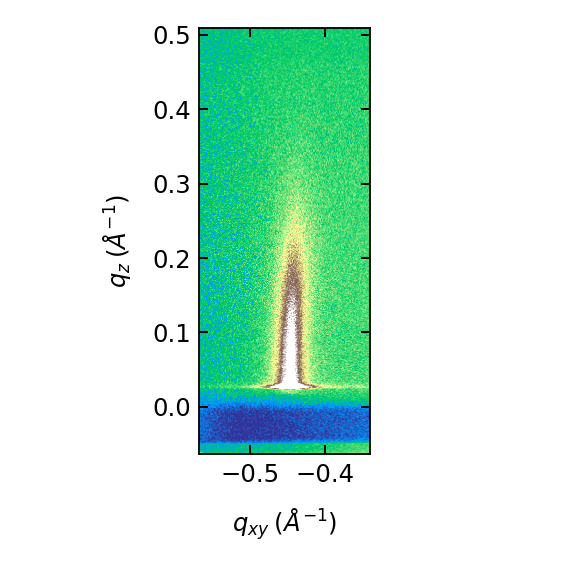

(<matplotlib.figure.Figure at 0x1ca0b9b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c743f98>)

In [22]:
clim = np.percentile(imgt, (1, 99))
my_implot(imgt, qxy, qz, mode='rsma', cmap="terrain", clim=clim)

## Make that a function
show_sample(df_row)

In [23]:
def show_sample(df_row):
    
    g_dict = {'intercept': 114.97875574477392, 'slope': 104.64780559689476}
    th_dict = {'intercept': 233.7958115183243, 'slope': 104.88468414880921}

    ### Detector pixel size (x,y)
    det_pix = [172e-6, 172e-6]
    
    ### Wavelength
    wl = 1240 / 14000.032 / 1e9

    ### Center-pixel and sample-to-detector distance
    centerx =  g_dict['intercept']
    centery = th_dict['intercept']

    ### sdd = slope of centX vs. gamma * pixel width
    sdd = g_dict['slope'] * 180/np.pi * det_pix[0]

    ### Beamcenter from sample view in meters from LOWER LEFT of detector
    poni1 = centery * det_pix[1]
    poni2 = centerx * det_pix[0]

    ### detector rotations from sample view
    rot1 = -np.deg2rad(df_row['gamma']) # GAMMA move detector to RIGHT, in-plane angle in radians
    rot2 = np.deg2rad(df_row['ttheta']) # 2THETA move detector down, out-of-plane angle
    rot3 = np.deg2rad(180) # This is apparently necessary

    ### Orientations and Angles
    sample_orientation = 1    # 1 is horizontal, 2 is vertical
    incident_angle = df_row['theta']     # indicent angle in deg
    tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")
    
    ### Define detector and transform function
    detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                         rot1 = rot1, rot2 = rot2, rot3 = rot3,
                         wavelength = wl, sample_orientation = sample_orientation,
                         incident_angle = incident_angle, tilt_angle = tilt_angle,
                         detector=detector)
    
    ### Transform data and plot
    imgt, qxy, qz = pg.transform_reciprocal(df_row.imageData, method='lut', correctSolidAngle=True, unit='A')
    clim = np.percentile(imgt, (1, 99))
    my_implot(imgt, qxy, qz, mode='rsma', cmap="terrain", clim=clim)
    
    return pg

## In-plane phi dependence of (001) peak

In [24]:
figfolder = 'F:\\N2200 Project\\figures\\ssrl\\7-2\\'

In [25]:
scan001 = df.loc[df['scan']==278].sort_values('phi')
scan001

,rawPath,pdiPath,fileName,scan,num,theta,ttheta,chi,phi,gamma,mu,rawData,imageData
507,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0125...,278,125,0.1,1.9,90.0,-100.0,3.5,-0.000005,"[[93, 100, 92, 78, 83, 109, 77, 82, 86, 90, 90...","[[-60, -57, -55, -72, -78, -36, -69, -69, -61,..."
506,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0124...,278,124,0.1,1.9,90.0,-98.0,3.5,-0.000005,"[[89, 90, 91, 101, 85, 91, 84, 84, 93, 89, 80,...","[[-64, -67, -56, -49, -76, -54, -62, -67, -54,..."
505,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0123...,278,123,0.1,1.9,90.0,-96.0,3.5,-0.000005,"[[91, 97, 94, 98, 86, 108, 95, 88, 107, 92, 89...","[[-62, -60, -53, -52, -75, -37, -51, -63, -40,..."
504,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0122...,278,122,0.1,1.9,90.0,-94.0,3.5,-0.000005,"[[111, 86, 89, 86, 103, 85, 86, 103, 94, 100, ...","[[-42, -71, -58, -64, -58, -60, -60, -48, -53,..."
503,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0121...,278,121,0.1,1.9,90.0,-92.0,3.5,-0.000005,"[[110, 73, 91, 85, 82, 94, 96, 97, 93, 88, 92,...","[[-43, -84, -56, -65, -79, -51, -50, -54, -54,..."
502,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0120...,278,120,0.1,1.9,90.0,-90.0,3.5,-0.000005,"[[85, 88, 98, 91, 74, 114, 77, 103, 93, 88, 96...","[[-68, -69, -49, -59, -87, -31, -69, -48, -54,..."
501,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0119...,278,119,0.1,1.9,90.0,-88.0,3.5,-0.000005,"[[87, 81, 85, 83, 94, 94, 93, 95, 91, 90, 87, ...","[[-66, -76, -62, -67, -67, -51, -53, -56, -56,..."
500,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0118...,278,118,0.1,1.9,90.0,-86.0,3.5,-0.000005,"[[83, 90, 95, 92, 86, 92, 91, 100, 96, 88, 85,...","[[-70, -67, -52, -58, -75, -53, -55, -51, -51,..."
499,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0117...,278,117,0.1,1.9,90.0,-84.0,3.5,-0.000005,"[[96, 92, 92, 93, 96, 90, 79, 92, 68, 83, 94, ...","[[-57, -65, -55, -57, -65, -55, -67, -59, -79,..."
498,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan278_0116...,278,116,0.1,1.9,90.0,-82.0,3.5,-0.000005,"[[77, 96, 92, 83, 95, 85, 81, 85, 87, 77, 90, ...","[[-76, -61, -55, -67, -66, -60, -65, -66, -60,..."


C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


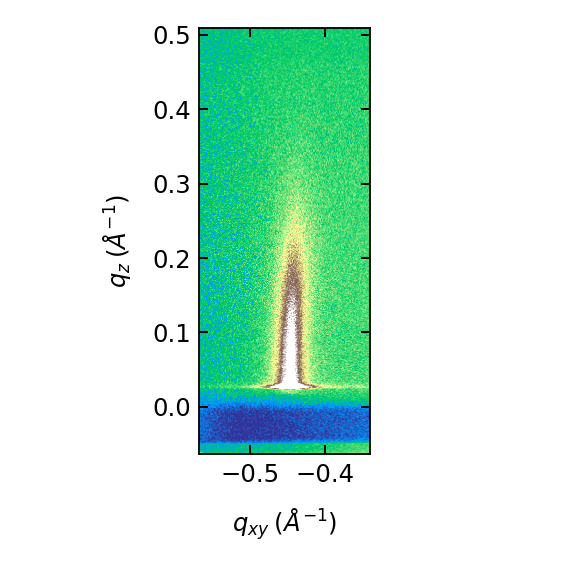

In [26]:
pg001 = show_sample(scan001.loc[457])
plt.savefig(os.path.join(figfolder,'{}_001_example.png'.format(system)))

<IPython.core.display.Javascript object>


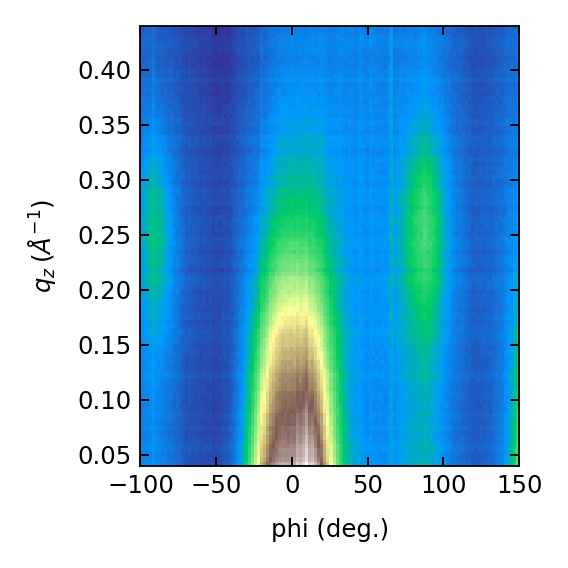

In [27]:
vlines001 = []

qx_pos = -0.447; qx_width = 0.06;
qz_min=0.04; qz_max=0.44;
phi_min=scan001['phi'].min(); phi_max=scan001['phi'].max()


for i,row in scan001.iterrows():
    int_box, q_box = pg001.profile_op_box(row.imageData,
                                      100, correctSolidAngle=True,
                                      ip_pos=qx_pos, ip_width=qx_width,
                                      op_range=(qz_min,qz_max), method='lut',
                                      unit='q_A^-1')
    vlines001.append(int_box)
    
phi_array_001 = np.vstack(vlines001).transpose()
phi_array_001.shape
plt.figure()
plt.imshow(phi_array_001,cmap='terrain',origin='lower',extent=[phi_min, phi_max, qz_min, qz_max],aspect='auto')
plt.xlabel(r'phi (deg.)'); plt.ylabel(r'$q_z \: (\AA^{-1})$')
plt.savefig(os.path.join(figfolder,'{}_001_linesvphi.png'.format(system)))

<IPython.core.display.Javascript object>


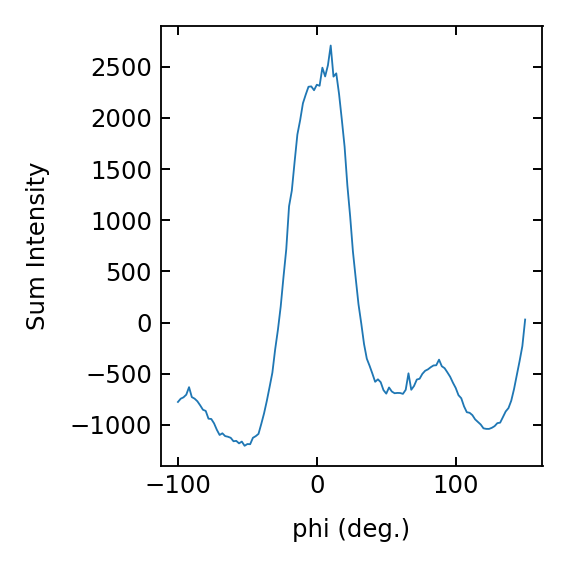

In [45]:
plt.figure()
plt.plot(scan001['phi'],
         np.sum(phi_array_001[np.where(q_box<0.13)[0],:], axis=0))
plt.xlabel(r'phi (deg.)'); plt.ylabel(r'Sum Intensity')
plt.savefig(os.path.join(figfolder,'{}_001_sumvphi.png'.format(system)))

## In-plane phi dependence of (200) peak
This one is more of an arc, so a sector will be more accurate

In [46]:
scan200 = df.loc[df['scan']==279].sort_values('phi')

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


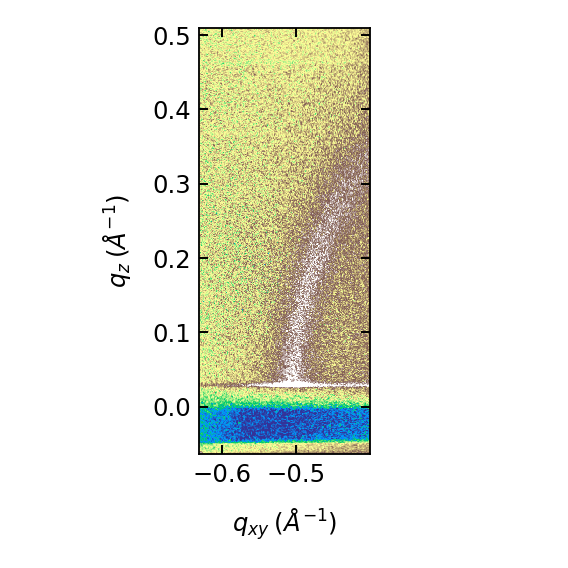

In [47]:
pg200 = show_sample(scan200.loc[513])
plt.savefig(os.path.join(figfolder,'{}_200_example.png'.format(system)))

<IPython.core.display.Javascript object>


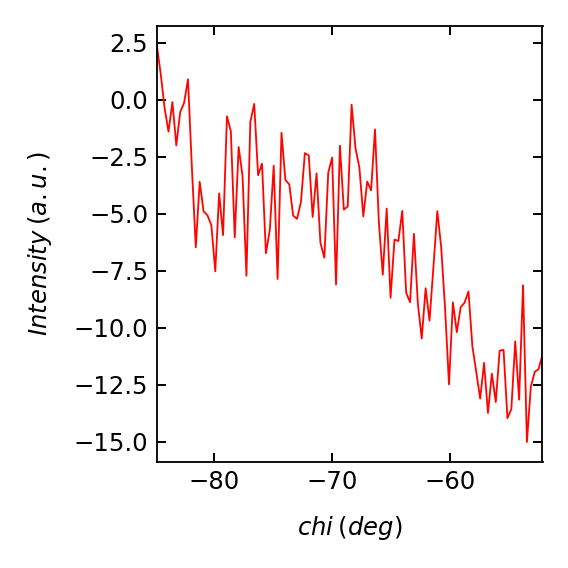

In [48]:
r_pos = 0.508; r_width = 0.04
chi_min = -85; chi_max = -52

int_sect_200, chi_sect_200 = pg200.profile_chi(scan200.loc[513]['imageData'], 100,
                                            correctSolidAngle=True,
                                            radial_pos=r_pos, radial_width=r_width,
                                            chi_range=(chi_min,chi_max), method='lut',
                                            unit='q_A^-1')
ppl.plot(chi_sect_200,int_sect_200, logy=False, mode='chi')

<IPython.core.display.Javascript object>


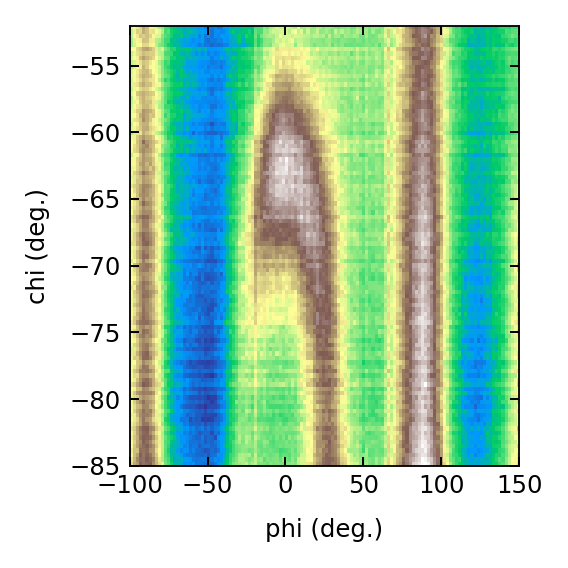

In [49]:
chisect200 = []

r_pos = 0.508; r_width = 0.04
chi_min = -85; chi_max = -52
phi_min=scan200['phi'].min(); phi_max=scan200['phi'].max()


for i,row in scan200.iterrows():

    int_sect_200, chi_sect_200 = pg200.profile_chi(row['imageData'], 100,
                                                correctSolidAngle=True,
                                                radial_pos=r_pos, radial_width=r_width,
                                                chi_range=(chi_min,chi_max), method='lut',
                                                unit='q_A^-1')
    chisect200.append(int_sect_200)
    
phi_array_200 = np.vstack(chisect200).transpose()
plt.figure()
plt.imshow(phi_array_200,cmap='terrain',origin='lower',extent=[phi_min, phi_max, chi_min, chi_max],aspect='auto')
plt.xlabel(r'phi (deg.)'); plt.ylabel(r'chi (deg.)')
plt.savefig(os.path.join(figfolder,'{}_200_linesvphi.png'.format(system)))

<IPython.core.display.Javascript object>


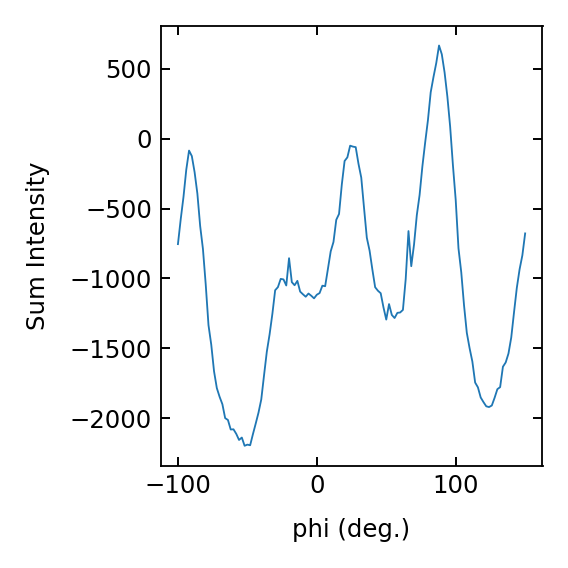

In [50]:
plt.figure()
plt.plot(scan200['phi'],
         np.sum(phi_array_200[np.where(chi_sect_200<-72)[0],:], axis=0))
plt.xlabel(r'phi (deg.)'); plt.ylabel(r'Sum Intensity')
plt.savefig(os.path.join(figfolder,'{}_200_sumvphi.png'.format(system)))

## In-plane phi dependence of (002) peak

In [51]:
scan002 = df.loc[df['scan']==280].sort_values('phi')
scan002

,rawPath,pdiPath,fileName,scan,num,theta,ttheta,chi,phi,gamma,mu,rawData,imageData
759,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0125...,280,125,0.1,1.9,90.0,-100.0,14.25,-0.000005,"[[58, 47, 32, 30, 22, 19, 15, 7, 6, 5, 6, 6, 7...","[[58.0, 47.0, 32.0, 30.0, 22.0, 19.0, 15.0, 7...."
758,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0124...,280,124,0.1,1.9,90.0,-98.0,14.25,-0.000005,"[[64, 40, 37, 30, 19, 12, 10, 12, 8, 8, 6, 10,...","[[64.0, 40.0, 37.0, 30.0, 19.0, 12.0, 10.0, 12..."
757,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0123...,280,123,0.1,1.9,90.0,-96.0,14.25,-0.000005,"[[52, 48, 23, 26, 19, 13, 12, 5, 12, 6, 8, 3, ...","[[52.0, 48.0, 23.0, 26.0, 19.0, 13.0, 12.0, 5...."
756,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0122...,280,122,0.1,1.9,90.0,-94.0,14.25,-0.000005,"[[58, 42, 32, 23, 18, 8, 12, 9, 6, 4, 3, 4, 3,...","[[58.0, 42.0, 32.0, 23.0, 18.0, 8.0, 12.0, 9.0..."
755,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0121...,280,121,0.1,1.9,90.0,-92.0,14.25,-0.000005,"[[58, 43, 26, 28, 22, 12, 11, 10, 10, 5, 4, 8,...","[[58.0, 43.0, 26.0, 28.0, 22.0, 12.0, 11.0, 10..."
754,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0120...,280,120,0.1,1.9,90.0,-90.0,14.25,-0.000005,"[[54, 47, 33, 28, 19, 14, 10, 12, 7, 3, 4, 10,...","[[54.0, 47.0, 33.0, 28.0, 19.0, 14.0, 10.0, 12..."
753,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0119...,280,119,0.1,1.9,90.0,-88.0,14.25,-0.000005,"[[56, 43, 31, 23, 18, 13, 7, 8, 4, 6, 3, 5, 6,...","[[56.0, 43.0, 31.0, 23.0, 18.0, 13.0, 7.0, 8.0..."
752,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0118...,280,118,0.1,1.9,90.0,-86.0,14.25,-0.000005,"[[47, 43, 29, 21, 21, 10, 8, 4, 8, 7, 6, 7, 6,...","[[47.0, 43.0, 29.0, 21.0, 21.0, 10.0, 8.0, 4.0..."
751,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0117...,280,117,0.1,1.9,90.0,-84.0,14.25,-0.000005,"[[55, 36, 27, 19, 14, 11, 11, 10, 3, 6, 4, 6, ...","[[55.0, 36.0, 27.0, 19.0, 14.0, 11.0, 11.0, 10..."
750,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,F:\N2200 Project\data\ssrl\7-2\raw\tol_hi_para...,b_rkline_nils_tol_hi_par_real.dat_scan280_0116...,280,116,0.1,1.9,90.0,-82.0,14.25,-0.000005,"[[50, 37, 29, 19, 11, 11, 8, 8, 10, 5, 3, 5, 5...","[[50.0, 37.0, 29.0, 19.0, 11.0, 11.0, 8.0, 8.0..."


C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


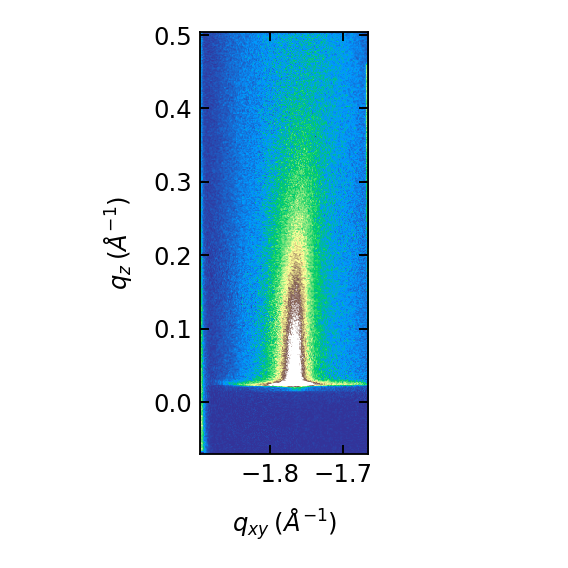

In [52]:
pg002 = show_sample(scan002.loc[scan002['phi']==0].iloc[0])
plt.savefig(os.path.join(figfolder,'{}_002_example.png'.format(system)))

<IPython.core.display.Javascript object>


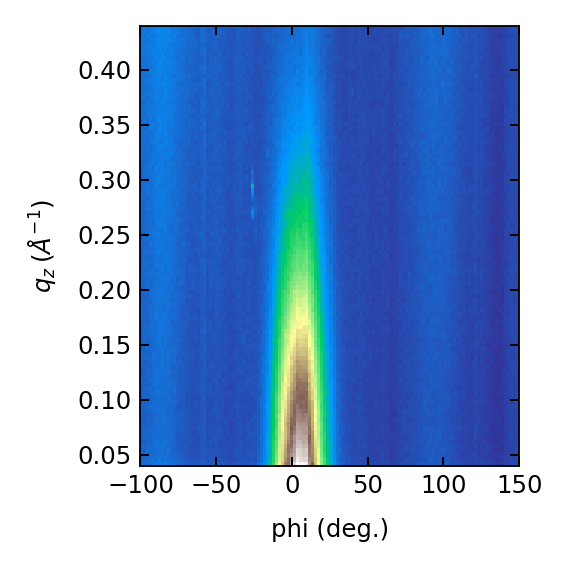

In [53]:
vlines002 = []

qx_pos = -1.766; qx_width = 0.04;
qz_min=0.04; qz_max=0.44;
phi_min=scan002['phi'].min(); phi_max=scan002['phi'].max()


for i,row in scan002.iterrows():
    
    int_box, q_box = pg002.profile_op_box(row.imageData,
                                      100, correctSolidAngle=True,
                                      ip_pos=qx_pos, ip_width=qx_width,
                                      op_range=(qz_min,qz_max), method='lut',
                                      unit='q_A^-1')
    vlines002.append(int_box)
    
phi_array_002 = np.vstack(vlines002).transpose()
phi_array_002.shape
plt.figure()
plt.imshow(phi_array_002,cmap='terrain',origin='lower',extent=[phi_min, phi_max, qz_min, qz_max],aspect='auto')
plt.xlabel(r'phi (deg.)'); plt.ylabel(r'$q_z \: (\AA^{-1})$')
plt.savefig(os.path.join(figfolder,'{}_002_linesvphi.png'.format(system)))

<IPython.core.display.Javascript object>


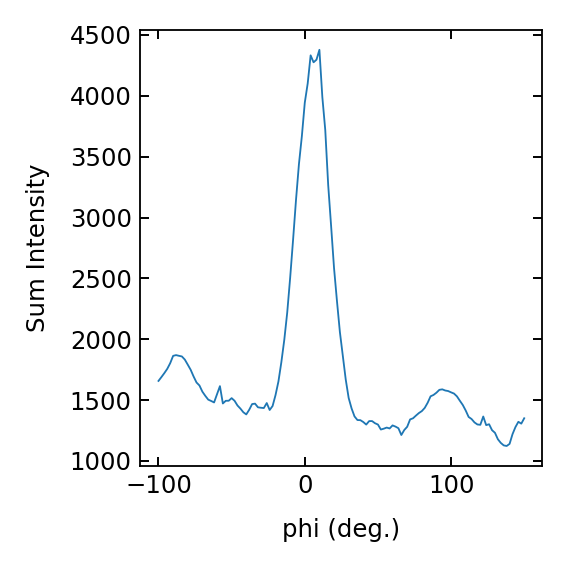

In [54]:
plt.figure()
plt.plot(scan002['phi'],np.sum(phi_array_002,axis=0))
plt.xlabel(r'phi (deg.)'); plt.ylabel(r'Sum Intensity')
plt.savefig(os.path.join(figfolder,'{}_002_sumvphi.png'.format(system)))

### Get in-plane sector

In [ ]:
int_sect, q_sect = pg.profile_sector(data, npt=1000, chi_pos=42,
                                 chi_width=4, radial_range=(1.35, 20),
                                 correctSolidAngle=True,
                                 method='lut', dark=dark)
ppl.plot(q_sect,int_sect, logy=True)

### Run peak fits over sectors starting from 88 back to 5 deg.
Initialize each fit from previous parameters

### Perform composite peak fits

In [ ]:
p100 = {'name': 'p100', 'set':1, 'cent': 2.3, 'min': 2.0, 'max': 3.0, 'sig': 0.1, 'amp': 1000, 'lb': 1.5, 'ub': 3.8}

p001 = {'name': 'p001', 'set':2, 'cent': 4.5, 'min': 4.0, 'max': 4.7, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}
p200 = {'name': 'p200', 'set':2, 'cent': 4.9, 'min': 4.7, 'max': 5.5, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}

p300 = {'name': 'p300', 'set':4, 'cent': 7.4, 'min': 7.0, 'max': 8.0, 'sig': 0.1, 'amp': 10, 'lb': 6.4, 'ub': 19.5}

p001a ={'name': 'p001a','set':4, 'cent': 8.8, 'min': 8.6, 'max': 9.0, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 19.5}
p002 = {'name': 'p002', 'set':4, 'cent': 9.5, 'min': 9.3, 'max': 9.8, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
p400 = {'name': 'p400', 'set':4, 'cent': 9.9, 'min': 9.7, 'max': 10.3, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}

phalo ={'name': 'phalo', 'set':4, 'cent': 14, 'min': 12, 'max': 15, 'sig': 0.2, 'amp': 10, 'lb': 14, 'ub': 19.5}
p010 = {'name': 'p010', 'set':4, 'cent': 16.0, 'min': 15.2, 'max': 16.5, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}
p002a ={'name': 'p002a','set':4, 'cent': 17.7, 'min': 17.2, 'max': 18, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}

df = pd.DataFrame.from_dict([p100,p001,p200,p300,p001a,p400,phalo,p010,p002a]) #p002
df

In [ ]:
x = q_sect
y = int_sect
color_list = ['#3cb44b','#0082c8','#f58231','#911eb4','#800000','#000080','#808000']
f1 = plt.figure()
plt.semilogy(x, y, 'r-')

for i in df['set'].unique():
    
    df_peaks = df.loc[df.set==i]
    
    # Build bounded x and y vectors
    lb = df_peaks.iloc[0].lb
    ub = df_peaks.iloc[0].ub
    lb_ind = int(np.where(x>=lb)[0][0])
    ub_ind = int(np.where(x>=ub)[0][0])
    xb = x[lb_ind:ub_ind]
    yb = y[lb_ind:ub_ind]
    
    # Initialize Baseline model
    comp_mod = []
    
    if i not in [1,2]:
        lin_mod = ConstantModel(prefix='lin_')
        pars = lin_mod.make_params(c=yb.min())
        comp_mod.append(lin_mod)
    else:
        lin_mod = ExponentialModel(prefix='lin_')
        pars = lin_mod.guess(y,x=x)
        comp_mod.append(lin_mod)

    # Add peaks
    for index, peak in df_peaks.iterrows():
        prefix = peak['name']+'_'
        peak_temp  = VoigtModel(prefix=prefix)
        
        pars.update( peak_temp.make_params())
        pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
        pars[prefix+'sigma'].set(peak['sig'])
        pars[prefix+'amplitude'].set(peak['amp'], min=0)
        
        comp_mod.append(peak_temp)
    
    # Build composite model
    comp_mod = np.sum(comp_mod)
    out = comp_mod.fit(yb, pars, x=xb)
    params_dict=out.params.valuesdict()
    
    # Store peak features in original dataframe
    for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
        df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
    
    # Add peaks to plot
    comps = out.eval_components(x=xb)
    plt.semilogy(xb, out.eval(x=xb), '-', color = color_list[i])
    for c in comps:
        try:
            plt.semilogy(xb, comps[c], '--', color = color_list[i])
        except:
            const_eval = np.ones(xb.shape)*comps[c]
            plt.semilogy(xb, const_eval, '--', color = color_list[i])

# Show the plot
f1.axes[0].set_ylim( bottom=np.min(y)/10, top=np.max(y)*1.3 )
plt.show()

In [ ]:
df_pole = pd.DataFrame()

for d in range(88,6,-2):
    
    print(d)
    
    # Get I vs Q for angle d
    int_sect, q_sect = pg.profile_sector(data, npt=1000, chi_pos=d,
                                     chi_width=4, radial_range=(1.35, 20),
                                     correctSolidAngle=True,
                                     method='lut', dark=dark)
    
    # Run peak fits, initialized from previous fit's parameters
    x = q_sect
    y = int_sect
    
    df_prev = df
    
    for i in df['set'].unique():
        
        df_peaks = df_prev.loc[df.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []

        if i not in [1,2]:
            lin_mod = ConstantModel(prefix='lin_')
            pars = lin_mod.make_params(c=yb.min())
            comp_mod.append(lin_mod)
        else:
            lin_mod = ExponentialModel(prefix='lin_')
            pars = lin_mod.guess(y,x=x)
            comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update( peak_temp.make_params())
            pars[prefix+'center'].set(peak['center'], min=peak['min'], max=peak['max'])
            pars[prefix+'sigma'].set(peak['sigma'])
            pars[prefix+'amplitude'].set(peak['amplitude'], min=0)

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
        df['chi']=d

    # Store results in pole figure dataframe
    df_pole = df_pole.append(df)

In [ ]:
df_pole[df_pole.name=='p200']

In [ ]:
pole_list

In [ ]:
h200 = [dfp['height'].loc[2] for dfp in df_pole['peaks'].tolist()]
plt.figure()
plt.plot(df_pole['chi'].tolist(),h200)

### Compute d-spacing, Herman's Orientation

In [ ]:
df['d-space']=2*np.pi / df['center'] * 10
df

In [ ]:
def Hermans(ii, chi):
    sin_chi = np.sin(np.deg2rad(chi))
    cos2chi = np.cos(np.deg2rad(chi)) ** 2
    return np.sum(ii * cos2chi * sin_chi) / np.sum(ii * sin_chi)

def interp_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

### Chi-profile, radially integrated, for Herman's calculation

In [ ]:
p200_q = float(df['center'][df['name']=='p200'])

cake, chi = pg.profile_chi(data, npt=200,
                           radial_pos=p200_q, radial_width=.3,
                           chi_range=(-88,88),
                           correctSolidAngle=True,
                           method='lut', dark=dark)

ppl.plot(chi,np.abs(interp_nans(cake) * np.sin(np.deg2rad(chi))),mode='chi')
print('Hermans Orientation Factor: ', Hermans(interp_nans(cake),chi))

### q-chi map, just because it's possible

In [ ]:
intensity, q_abs, chi = pg.transform_polar(data,
                                           npt=(2000, 400), q_range=(0,20),
                                           correctSolidAngle=True,
                                           method='splitpix', dark=dark)

ppl.implot(intensity, q_abs, chi, mode='polar', cmap='terrain', clim=np.percentile(intensity,(0.1,99.5)))

### Generate cropped, processed spectrum for all files

Previous cells must have been run for this to work.

In [ ]:
for ind,row in df.iterrows():
    
    data = fabio.open(row['fullpath']).data
    data = np.flipud(data)
    
    if row['exp_time'] == 30:
        dark = np.flipud(fabio.open(dark30file).data)
    else: 
        dark = np.flipud(fabio.open(dark90file).data)
    
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                         rot1 = rot1, rot2 = rot2, rot3 = rot3,
                         wavelength = wl, sample_orientation = sample_orientation,
                         incident_angle = incident_angle, tilt_angle = tilt_angle,
                         detector=detector)

    imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=dark)
    logimg = np.log(imgt+1)
    
    figfile = (row['fullpath'].split('.')[:-1][0]+'.png').replace('data','figures')
    print(figfile)
    clim = np.percentile(logimg[logimg>0], (3, 99.99))
    my_implot(logimg,qxy,qz,mode='rsma',cmap='terrain',clim=clim,xlim=(-.6,2),ylim=(-.05,2),show=False,filename=figfile)
    plt.close()

### Write a master function to automate analysis

In [ ]:
def analyze_n22(dfrow):
    
    # Open file, get data and dark spectra
    data_file = dfrow['fullpath']
    print(dfrow['filename'])
    data = fabio.open(data_file).data
    data = np.flipud(data)

    if dfrow['exp_time'] == 30:
        dark = np.flipud(fabio.open(dark30file).data)
    else: 
        dark = np.flipud(fabio.open(dark90file).data)
        
        
    # Setup detector and transform
    ### Detector pixel size
    det_pix = [73.242e-6, 73.242e-6]
    detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

    ### Wavelength
    wl = 0.976254e-10

    ### Center-pixel and sample-to-detector distance
    centerx =  1532.42
    centery = data.shape[0]-3034.23   # This is because I had to flip it upside-down
    sdd = 0.339316

    ### Beamcenter from sample view in meters from lower left of detector
    poni1 = centery * det_pix[1]; poni2 = centerx * det_pix[0]

    ### detector rotations from sample view
    rot1 = deldel /180 * np.pi # move detector to right, in-plane angle# in radians
    rot2 = 0.0    /180 * np.pi # move detector down, out-of-plane angle
    rot3 = 0.0    /180 * np.pi # clockwise rotation

    ### Orientations and Angles
    sample_orientation = 1    # 1 is horizontal, 2 is vertical
    incident_angle = dfrow['theta']     # indicent angle in deg
    tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")
    
    ### Initialize the transform
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)
    
    # in-plane profile for analysis
    int_in, q_in = pg.profile_ip_box(data, npt=1000, op_pos=0,
                                 op_width=1, ip_range=(1.35, 20),
                                 correctSolidAngle=True,
                                 method='lut', dark=dark)
    
    # Fitting parameters
    p100 = {'name': 'p100', 'set':1, 'cent': 2.3, 'min': 2.2, 'max': 2.6, 'sig': 0.1, 'amp': 1000, 'lb': 1.5, 'ub': 3.8}

    p001 = {'name': 'p001', 'set':2, 'cent': 4.5, 'min': 4.3, 'max': 4.7, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}
    p200 = {'name': 'p200', 'set':2, 'cent': 4.9, 'min': 4.7, 'max': 5.0, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}

    p300 = {'name': 'p300', 'set':3, 'cent': 7.4, 'min': 7.0, 'max': 8.0, 'sig': 0.1, 'amp': 10, 'lb': 6.4, 'ub': 8.3}

    p001a ={'name': 'p001a','set':4, 'cent': 8.8, 'min': 8.6, 'max': 9.0, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
    p002 = {'name': 'p002', 'set':4, 'cent': 9.5, 'min': 9.3, 'max': 9.8, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
    p400 = {'name': 'p400', 'set':4, 'cent': 9.9, 'min': 9.7, 'max': 10.3, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}

    p002a ={'name': 'p002a','set':5, 'cent': 17.7, 'min': 17.2, 'max': 18, 'sig': 0.1, 'amp': 10, 'lb': 16.7, 'ub': 18.7}

    df = pd.DataFrame.from_dict([p100,p001,p200,p300,p001a,p002,p400,p002a])
    
    # Perform Peak Fits
    x = q_in
    y = int_in

    for i in df['set'].unique():

        df_peaks = df.loc[df.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []
        lin_mod = LinearModel(prefix='lin_')
        pars = lin_mod.make_params(intercept=yb.min(), slope=0)
        comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update( peak_temp.make_params())
            pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
            pars[prefix+'sigma'].set(peak['sig'])
            pars[prefix+'amplitude'].set(peak['amp'], min=0)

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
            
    # Store results of peak fits in dfrow
    dfrow['peak_fits'] = df
    
    
    # Get Herman's Orientation and store
    p200_q = float(df['center'][df['name']=='p200'])
    
    cake, chi = pg.profile_chi(data, npt=200,
                               radial_pos=p200_q, radial_width=.3,
                               chi_range=(3,88),
                               correctSolidAngle=True,
                               method='lut', dark=dark)
    
    dfrow['Hermans'] = Hermans(interp_nans(cake),chi)
    
    return dfrow

In [ ]:
df_test = df.iloc[0]
df_test

In [ ]:
res = analyze_n22(df_test)

In [ ]:
df_res = pd.DataFrame()
for i,row in df.iterrows():
    try:
        df_res = df_res.append(analyze_n22(row))
    except:
        pass
    
df_res

In [ ]:
df_res[['filename','solvent','speed','grooves','sample_phi','theta','Hermans']]

In [ ]:
df_res = 

In [ ]:
df_res.to_csv(path_or_buf='n22_waxs_results.csv')

In [ ]:
df_res.to_pickle('n22_waxs_pickle')

In [ ]:
df_new = pd.read_pickle('n22_waxs_pickle')
df_new

In [ ]:
df_new